<a href="https://colab.research.google.com/github/Pritishsingla/Titanic_kaggle/blob/master/Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tqdm
import sklearn
import datetime
import pickle as pkl
import random
%matplotlib inline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [7]:
train = train.set_index('PassengerId')
train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


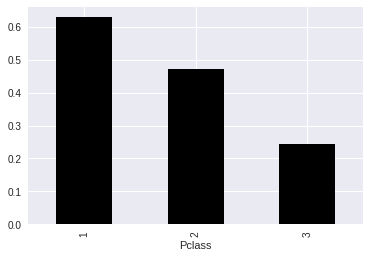

In [8]:
train.groupby(['Pclass']).agg('mean')['Survived'].plot(kind='bar', color='k')

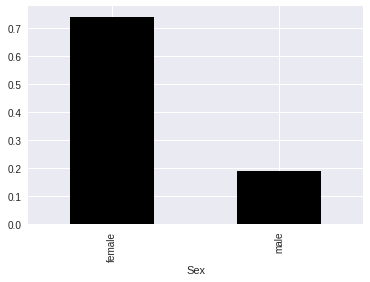

In [9]:
train.groupby(['Sex']).agg('mean')['Survived'].plot(kind='bar', color='k')

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

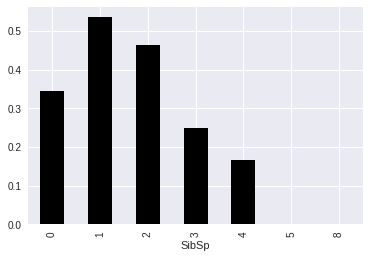

In [10]:
train.groupby('SibSp').agg('mean')['Survived'].plot(kind='bar', color='k')
train.SibSp.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

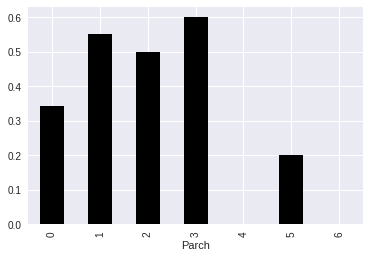

In [11]:
train.groupby('Parch').agg('mean')['Survived'].plot(kind='bar', color='k')
train.Parch.value_counts()# group values

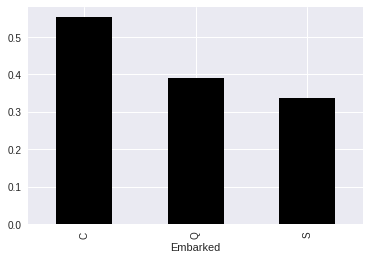

In [12]:
train.groupby('Embarked').agg('mean')['Survived'].plot(kind='bar', color='k')

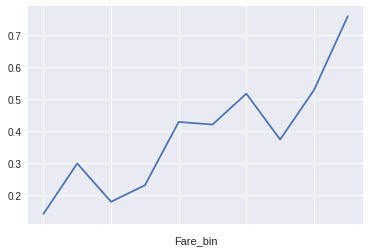

In [13]:
train['Fare_bin'] = pd.qcut(train['Fare'], q=10, labels=range(1, 10+1))
train.groupby('Fare_bin').agg('mean')['Survived'].plot()

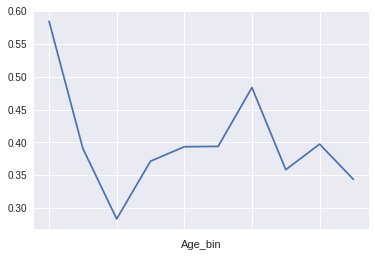

In [57]:
train['Age_bin'] = pd.qcut(train['Age'], q=10)
train.groupby('Age_bin').agg('mean')['Survived'].plot()
train['Child_ind'] = train['Age'] <14.0

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_2, dtype: int64

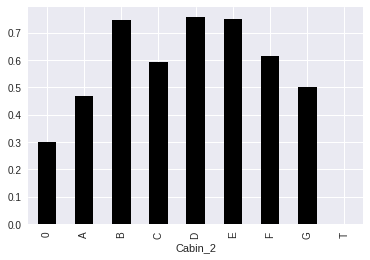

In [92]:
train['Cabin_2'] = train['Cabin'].apply(lambda x: x[0] if type(x)==str else 0)
train.groupby('Cabin_2').agg('mean')['Survived'].plot(kind='bar', color='k')

train.Cabin_2.value_counts()

In [0]:
train['Cabin_2'] = train['Cabin_2'].apply(lambda x: x if x not in ['F', 'G', 'T'] else 'Other')

In [62]:
train['Surname'] = train['Name'].apply(lambda x: x.split(',')[0])
train[['Surname', 'Name']].head()
train['Salutation'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0][1:])
train[[ 'Name', 'Surname', 'Salutation']].head()
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Fare_bin', 'Age_bin', 'Cabin_2',
       'Surname', 'Salutation', 'Name_len', 'Nickname', 'Age_null_ind',
       'Age_estimated_ind', 'ticket_has_letters', 'Child_ind'],
      dtype='object')

In [0]:
train['Salutation'].value_counts()
train['Salutation'] = train['Salutation'].apply(lambda x: x if x in ['Mr', 'Miss', 'Master', 'Mrs'] else 'Other' )

In [20]:
train['Name_len'] = train.Name.apply(lambda x: len(x.split(' '))-1)
train[['Name', 'Name_len']].head(10)

,Name,Name_len
PassengerId,,
1,"Braund, Mr. Owen Harris",3
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",6
3,"Heikkinen, Miss. Laina",2
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",6
5,"Allen, Mr. William Henry",3
6,"Moran, Mr. James",2
7,"McCarthy, Mr. Timothy J",3
8,"Palsson, Master. Gosta Leonard",3
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",6


In [21]:
train['Nickname'] = train['Name'].apply(lambda x : 1 if '(' in x else 0)
train[['Name', 'Name_len', 'Nickname']].head(10)

,Name,Name_len,Nickname
PassengerId,,,
1,"Braund, Mr. Owen Harris",3,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",6,1
3,"Heikkinen, Miss. Laina",2,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",6,1
5,"Allen, Mr. William Henry",3,0
6,"Moran, Mr. James",2,0
7,"McCarthy, Mr. Timothy J",3,0
8,"Palsson, Master. Gosta Leonard",3,0
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",6,1


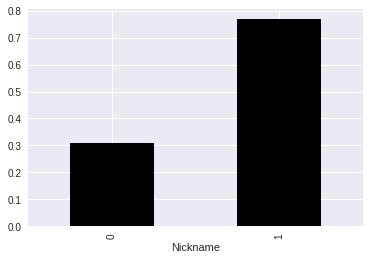

In [22]:
train.groupby('Nickname').agg('mean')['Survived'].plot(kind='bar', color='k')

In [94]:
train.groupby('Salutation').agg('mean')['Age']

Salutation
Master     4.574167
Miss      21.773973
Mr        32.368090
Mrs       35.898148
Other     42.384615
Name: Age, dtype: float64

In [0]:
train['Age_null_ind'] = train.Age.isnull().astype(int)
train['Age_estimated_ind'] = train.Age.apply(lambda x: x%1 >0).astype(int)

In [29]:
train[train.Age < 1]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_bin,Age_bin,Cabin_2,Surname,Salutation,Name_len,Nickname,Age_null_ind,Age_estimated_ind
PassengerId,,,,,,,,,,,,,,,,,,,,
79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S,8,"(0.419, 14.0]",0,Caldwell,Master,3,0,0,1
306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,10,"(0.419, 14.0]",C,Allison,Master,3,0,0,1
470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C,6,"(0.419, 14.0]",0,Baclini,Miss,3,0,0,1
645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C,6,"(0.419, 14.0]",0,Baclini,Miss,2,0,0,1
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S,6,"(0.419, 14.0]",0,Hamalainen,Master,2,0,0,1
804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,4,"(0.419, 14.0]",0,Thomas,Master,3,0,0,1
832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,6,"(0.419, 14.0]",0,Richards,Master,3,0,0,1


In [0]:
train[train['Age'].isnull()]

In [49]:
import regex as re
train['ticket_has_letters']  = train['Ticket'].apply(lambda x: bool(re.search('[a-zA-Z]', x)))
train[['ticket_has_letters', 'Ticket']].head()

,ticket_has_letters,Ticket
PassengerId,,
1,True,A/5 21171
2,True,PC 17599
3,True,STON/O2. 3101282
4,False,113803
5,False,373450


In [50]:
train.groupby('ticket_has_letters').agg('mean')['Survived']

ticket_has_letters
False    0.384266
True     0.382609
Name: Survived, dtype: float64

In [52]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Fare_bin', 'Age_bin', 'Cabin_2',
       'Surname', 'Salutation', 'Name_len', 'Nickname', 'Age_null_ind',
       'Age_estimated_ind', 'ticket_has_letters'],
      dtype='object')

In [73]:
median_age_salutation = train[~train.Age.isnull()].groupby('Salutation').agg(['median'])['Age']
median_age_salutation

,median
Salutation,
Master,3.5
Miss,21.0
Mr,30.0
Mrs,35.0
Other,44.5


In [76]:
train['Age_imputated'] = train.apply(lambda x: x if x['Age'] == np.nan else median_age_salutation.loc[x['Salutation']], axis=1)
train[train.Age.isnull()][['Salutation', 'Age_imputated']].head()

,Salutation,Age_imputated
PassengerId,,
6,Mr,30.0
18,Mr,30.0
20,Mrs,35.0
27,Mr,30.0
29,Miss,21.0


In [77]:
train[~train.Age.isnull()].groupby('Salutation').agg(['median', 'mean', 'std'])['Age']

,median,mean,std
Salutation,,,
Master,3.5,4.574167,3.619872
Miss,21.0,21.773973,12.990292
Mr,30.0,32.368090,12.708793
Mrs,35.0,35.898148,11.433628
Other,44.5,42.384615,13.200233


In [97]:
train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Cabin_2,Surname,Salutation,Name_len,Nickname,Age_null_ind,Age_estimated_ind,ticket_has_letters,Child_ind,Age_imputated
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,0,Braund,Mr,3,0,0,0,True,False,30.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,C,Cumings,Mrs,6,1,0,0,True,False,35.0


In [0]:
categorical_columns = ['Sex', 'Pclass', 'Embarked', 'Cabin_2', 'Salutation', 'Age_bin', 'Fare_bin']
# pd.get_dummies(train, columns=categorical_columns, prefix=categorical_columns, drop_first=1).head()